**CONSIGNAS PARA TODOS LOS EJERCICIOS:**

1.   En el caso de utilizar una Regresión Logística grafique sus parámetros con la función AA_utils.visualizar_parametros
2.   Grafique e interprete la matriz de confusión de la predicción sobre el set de test con la función AA_utils.visualizar_confusion_matrix
3.   Elabore un reporte de métricas tanto para la predicción de train como para la de test con la función AA_utils.print_classification_report
4.   En los casos de clasificación binaria grafique e interprete la curva ROC con la función AA_utils.visualizar_curva_ROC
5.   En los caso de clasificación de dos variables grafique la función de transferencia y la frontera de decisión con las funciones AA_utils.visualizar_funcion_transferencia_2D y AA_utils.visualizar_frontera_de_desicion_2D
6.   En los casos de clasificación binaria de una variable grafique la curva logística con la función AA_utils.visualizar_curva_logistica

# **CLASIFICACIÓN BINARIA DE UNA VARIABLE CON REGRESIÓN LOGÍSTICA**

**EJERCICIO 1)**


***Clasificación binaria con 1 variable***: Analice el código de ejemplo en ejemplo_clasificacion_binaria_una_variable_regresion_logistica.py. El script entrena un modelo de regresión logística para clasificar tumores como malignos o benignos en base a su tamaño. El script también muestra la función sigmoidea entrenada (distribución de probabilidades). Analice cómo cambia la curva entrenada al cambiar el parámetro class_weight.

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, classification_report

from mpl_toolkits.axes_grid1 import make_axes_locatable

# **AA UTILS**

In [97]:
def if_dataframe_to_numpy(data):
    return data.to_numpy() if isinstance(data, pd.DataFrame) or isinstance(data, pd.Series) else data

def plot_2d(modelo, X, X_train, X_test, y_train, y_test, boundry_function):

    assert X.shape[1] == 2, f"X debe tener solo dos variables de entrada (tiene {X.shape[1]})"

    X = if_dataframe_to_numpy(X)
    X_train = if_dataframe_to_numpy(X_train)
    X_test = if_dataframe_to_numpy(X_test)

    plt.figure()
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    Z = np.c_[xx.ravel(), yy.ravel()]
    Z = boundry_function(modelo, Z)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.colorbar()

    plt.scatter(X_train[:, 0], X_train[:, 1], marker="o", c=y_train, label='Training')
    plt.scatter(X_test[:, 0], X_test[:, 1], marker="+", c=y_test, s=80, label='Testing')
    plt.legend()
    plt.show()

def print_classification_report(y_true, y_pred):
    print(classification_report(y_true, y_pred))

def visualizar_parametros(modelo, mostrar_bias, feature_names=[], target_name='target'):
    parametros = pd.DataFrame(modelo.coef_, columns=feature_names if len(feature_names) > 0 else range(modelo.coef_.shape[1]))

    if mostrar_bias:
        parametros['bias'] = modelo.intercept_

    parametros.T.plot(kind='bar')

    if hasattr(modelo, 'classes_'):
        if len(modelo.classes_) <= 2:
            plt.legend([target_name])
        else:
            plt.legend(list(modelo.classes_))
    else:
        plt.legend([target_name])

    plt.show()

def visualizar_curva_logistica(modelo, X, y, feature_name='target'):

    assert X.shape[1] == 1, f"X debe tener solo una variable de entrada (tiene {X.shape[1]})"

    X = if_dataframe_to_numpy(X)

    plt.figure()
    plt.scatter(X, y, c=y, s=50)
    plt.xlabel(feature_name)
    plt.grid()

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x_graph = np.linspace(x_min, x_max)
    y_graph = modelo.predict_proba(x_graph.reshape(-1, 1))[:, 1]
    plt.plot(x_graph, y_graph)
    plt.show()

def visualizar_frontera_de_desicion_2D(modelo, X, X_train, X_test, y_train, y_test):
    plot_2d(modelo, X, X_train, X_test, y_train, y_test, lambda modelo, Z: modelo.predict(Z))

def visualizar_funcion_transferencia_2D(modelo, X, X_train, X_test, y_train, y_test):

    if hasattr(modelo, 'predict_proba') and callable(getattr(modelo, 'predict_proba')):
        plot_2d(modelo, X, X_train, X_test, y_train, y_test, lambda modelo, Z: modelo.predict_proba(Z)[:, 1])
    else:
        raise ValueError("no se puede visualizar funcion de transferencia")

def visualizar_confusion_matrix(real_target, pred_target,
                                classes=[],
                                normalize=False,
                                title='Matriz de confusión',
                                cmap=plt.cm.Blues):

    if (len(classes) == 0):
        classes = [str(i) for i in range(int(max(real_target) + 1))]  # nombres de clases consecutivos

    cm = confusion_matrix(real_target, pred_target)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", size=16)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def visualizar_curva_ROC(modelo, X, y):

    assert len(set(y)) <= 2, f"El dataset debe ser binario (hay {len(set(y))}) clases"

    y_score = modelo.predict_proba(X)[:, 1]  # se queda con la clase 1

    false_positive_rate, true_positive_rate, threshold = roc_curve(y, y_score)

    precision, recall, _ = precision_recall_curve(y, y_score)

    # ROC
    plt.figure()
    plt.title('ROC. Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.2f)' % roc_auc_score(y, y_score))
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
    plt.legend(loc="lower right")
    plt.ylabel('True Positive Rate (Recall)')
    plt.xlabel('False Positive Rate (1- Especificidad)')
    plt.show()

    # precision-recall curve
    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve')
    plt.show()

def elegir_imagen_al_azar(X, pixeles_ancho, pixeles_alto):
    indice = np.random.randint(0, X.shape[0])
    img_i = np.reshape(X[indice, :], (pixeles_ancho, pixeles_alto))
    plt.figure()
    plt.imshow(img_i, 'gray')
    plt.title('Dato aleatorio')
    plt.show()
    return X[indice].reshape(1, -1), indice

def visualizar_parametros_para_imagenes(modelo, cantidad_de_clases, pixeles_ancho=28, pixeles_alto=28):

    if hasattr(modelo, 'coef_'):
        w = modelo.coef_
    elif hasattr(modelo, 'coefs_') and (modelo.coefs_) == 1:
        w = modelo.coefs_[0]
    else:
        raise "para visualizar los parametros de la red es necesario tener cero capas ocultas"

    colorbar_max = np.abs(np.max(w))
    w_r = np.reshape(w, (cantidad_de_clases, pixeles_ancho, pixeles_alto))
    fig, ax = plt.subplots(2, cantidad_de_clases // 2)
    plt.suptitle('Coeficientes aprendidos para cada clase, \nagrupados en forma matricial de 28x28')
    index = 0
    for row in range(0, 2):
        for col in range(0, cantidad_de_clases // 2):
            colorbar_max = max(np.abs(np.max(w_r[index, :, :])), np.abs(np.min(w_r[index, :, :])))
            ax_im = ax[row][col].imshow(w_r[index, :, :], cmap='seismic', vmin=-colorbar_max, vmax=colorbar_max)
            ax[row][col].get_xaxis().set_visible(False)
            ax[row][col].get_yaxis().set_visible(False)
            ax[row][col].set_title(str(index))
            divider = make_axes_locatable(ax[row][col])
            cax = divider.append_axes("right", size="5%", pad=0.05)

            fig.colorbar(ax_im, ax=ax[row][col], cax=cax)
            index += 1
    plt.show()

def visualizar_ajuste_por_regresion(modelo, X_train, X_test, y_train, y_test,
                                    feature_name='X', target_name='target'):
    plt.scatter(X_train, y_train, c='blue', s=40, alpha=0.9, label='Training')
    plt.scatter(X_test, y_test, c='red', s=50, alpha=0.5, label='Testing')
    plt.xlabel(feature_name)
    plt.ylabel(target_name)
    plt.legend()
    plt.grid()

    X_train = if_dataframe_to_numpy(X_train)
    X_test = if_dataframe_to_numpy(X_test)

    x_max = max(max(X_train), max(X_test))
    x_min = min(min(X_train), min(X_test))

    x_plot = np.linspace(x_min, x_max, 100)
    y_plot = modelo.predict(x_plot.reshape(-1, 1))
    plt.plot(x_plot, y_plot, 'g--', linewidth=5)
    plt.show()

def visualizar_curva_error_entrenamiento(modelo):
    plt.plot(modelo.loss_curve_)
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.legend(['Train'])
    plt.show()


# **BREAST CANCER RADIUS**

**CARGA DE DATOS**

In [98]:
data = pd.read_csv(r"https://raw.githubusercontent.com/KevinFDI/IML_Practica_3/main/Pr%C3%A1ctica/datasets/breast_cancer_radius.csv")

**HAGO UNA VISTA RÁPIDA DEL DATASET Y ANALIZO SI HAY VALORES NULOS**

In [99]:
data.head()

,mean radius,target
0,17.99,1
1,20.57,1
2,19.69,1
3,11.42,1
4,20.29,1


In [100]:
data.isnull().sum()

mean radius    0
target         0
dtype: int64

In [101]:
round(data.describe(), 2)

,mean radius,target
count,569.00,569.00
mean,14.13,0.37
std,3.52,0.48
min,6.98,0.00
25%,11.70,0.00
50%,13.37,0.00
75%,15.78,1.00
max,28.11,1.00


**PREPROCESAMIENTO**

In [102]:
X = data.drop(columns=['target'])
y = data['target']

print(f'''
      ====================================================================================================
      El problema de clasificación es de {X.shape[1]} features ---(prediciendo)---> {len(set(y))} clases
      ====================================================================================================
      ''')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

NORMALIZAR = True

if NORMALIZAR:
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)


      El problema de clasificación es de 1 features ---(prediciendo)---> 2 clases
      


**MODELADO**

In [103]:
modelo = LogisticRegression()
modelo.fit(X_train, y_train)

# CAMBIO DEL PARÁMETRO CLASS_WEIGHT

from sklearn.utils import class_weight

weights = {0:0.3, 1:0.7} # Determina si tengo más falsos positivos o más falsos positivos
modelo_2 = LogisticRegression(class_weight=weights)
modelo_2.fit(X_train, y_train)

LogisticRegression(class_weight={0: 0.3, 1: 0.7})

Con el parámetro class_weight se puede solucionar el problema del desbalance de clases al momento de entrenar el modelo. Este parámetro es un diccionario que indica el peso que se le dará a cada clase dentro de la función de error durante el entrenamiento.

A medida que se inclina el peso hacia una u otra clase, aumentará el Recall y disminuirá el Precision, o viceversa.

Esto quiere decir, que a medida que cambie, tendré más Falsos Positivos o más Falsos Negativos. Hay que definir para dónde quiere cada uno inclinar la balanza.

**EVALUACIÓN**

El "**Accuracy**" sÓlo sirve como promedio de clasificación general del modelo. Muestra cómo se comporta el modelo teniendo en cuenta tanto los "True Positives" como los "True Negatives".

La "**Precision**" muestra cuántos ítems reconocidos son realmente relevantes.

El "**Recall**" dice cuántos ítems relevantes fueron realmente seleccionados.

El "**Support**" muestra con cuántos datos se están calculando los valores anteriores.

Las métricas sobre el conjunto de **training** dicen cómo se entrenó el modelo, que tan bien se entrenó.

Si el Accuracy es malo en está métrica (ej. 40%), entonces ya el modelo es malo.

Una vez que este modelo es bueno (por encima del 80-90%) se pasa a analizar el de testing.

In [104]:
# 3

print_classification_report(y_train, modelo.predict(X_train))

print("######################################################")
print("\n\n \t      CON CAMBIO EN EL PARAMETRO CLASS_WEIGTH \n")
print("\t      --------------------------------------- \n")

print_classification_report(y_train, modelo_2.predict(X_train))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91       287
           1       0.88      0.80      0.84       168

    accuracy                           0.89       455
   macro avg       0.88      0.87      0.87       455
weighted avg       0.89      0.89      0.88       455

######################################################


 	      CON CAMBIO EN EL PARAMETRO CLASS_WEIGTH 

	      --------------------------------------- 

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       287
           1       0.77      0.86      0.81       168

    accuracy                           0.85       455
   macro avg       0.84      0.85      0.84       455
weighted avg       0.86      0.85      0.85       455



Las métricas sobre el conjunto de **testing** indica que tan bien funciona el modelo para datos nuevos.

Si esta modelo es maso menos igual al de training entonces es un buen modelo.

En cambio, si tenemos valores mucho más bajos, podríamos estar bajo un sobreajuste. 

In [105]:
# 3

print_classification_report(y_test, modelo.predict(X_test))

print("######################################################")
print("\n\n \t      CON CAMBIO EN EL PARAMETRO CLASS_WEIGTH \n")
print("\t      --------------------------------------- \n")

print_classification_report(y_test, modelo_2.predict(X_test))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90        70
           1       0.91      0.73      0.81        44

    accuracy                           0.87       114
   macro avg       0.88      0.84      0.85       114
weighted avg       0.87      0.87      0.86       114

######################################################


 	      CON CAMBIO EN EL PARAMETRO CLASS_WEIGTH 

	      --------------------------------------- 

              precision    recall  f1-score   support

           0       0.89      0.89      0.89        70
           1       0.82      0.82      0.82        44

    accuracy                           0.86       114
   macro avg       0.85      0.85      0.85       114
weighted avg       0.86      0.86      0.86       114



OBSERVACIÓN: Tal como lo vimos en la clase teórica, tanto para el train como para el test, al cambiar el parámetro class_weight aumenta el recall de una variable teniendo como contrapartida una disminución de la presicion y viceversa. Lo contrario ocurrirá con la otra variable.

En el siguiente gráfico de **Matriz de Confusión** se puede observar cómo se comporta el modelo para cada una de las clases.

Este gráfico se analiza de la siguiente manera:
*   Las **filas** representan la etiqueta real de cada clase.
*   Las **columnas** representan la predicción del modelo entrenado.
*   La **diagonal principal** representa el correcto funcionamiento del modelo.
*   **Fuera de la diagonal**: errores.



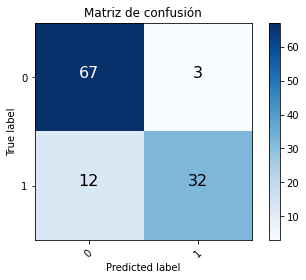


########################################################

 CON CAMBIO EN EL PARAMETRO CLASS_WEIGTH 

--------------------------------------- 



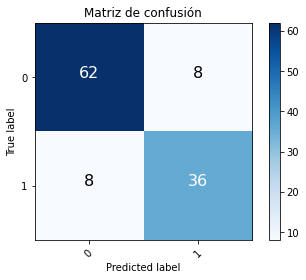

In [106]:
# 2

visualizar_confusion_matrix(y_test, modelo.predict(X_test))

print("\n########################################################")
print("\n CON CAMBIO EN EL PARAMETRO CLASS_WEIGTH \n")
print("--------------------------------------- \n")

visualizar_confusion_matrix(y_test, modelo_2.predict(X_test))

El 0 representa a los valores benignos, mientras que el 1 a los valores malignos.
Como mencioné antes de la gráfica, los valores de la diagonal principal (los cuadrados más oscuros) son aquellos valores que se representan correctamente, mientras que el resto (la otra diagonal con cuadrados más claros) respresentan los valores que se predijieron incorrectamente.

Con el **class_weigth** a medida que se inclina el peso hacia una u otra clase, aumentará el Recall y disminuirá el Precision, o viceversa.

En este caso inclino el peso de la variable para aumentar más los valores de los falsos positivos y disminuir la de los falsos negativos.

Esto lo hago para prevenir (disminuir) los casos que se podrían determinar como falso negativo en un test de cancer. Desde esta perspectiva prefiero que la balanza la incline a los falsos positivos.

Las **Curvas ROC** (Receiver Operating Characteristic) muestra cómo se comporta un modelo binario al cambiar el umbral de detección.
*   True Positive Rate = Sensitividad = Recall= TP/(TP+FN)
*   False Positive Rate= 1 - Especificidad= 1- TN/(FP+TN)

Las **Curvas Precision-Recall** se computan de igual modo que las curvas ROC pero grafican el funcionamiento del modelo para estas métricas.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


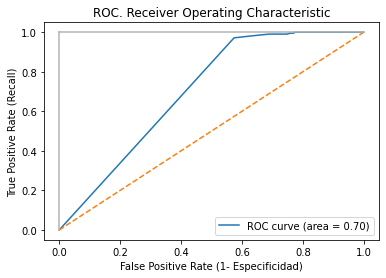

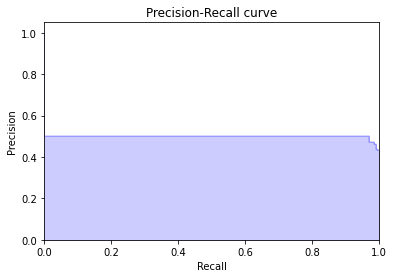


################################################

 CON CAMBIO EN EL PARAMETRO CLASS_WEIGTH 

--------------------------------------- 



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


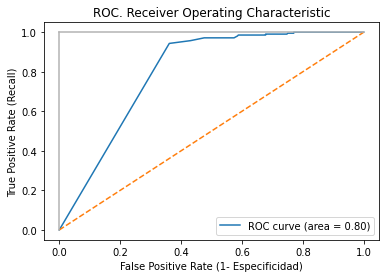

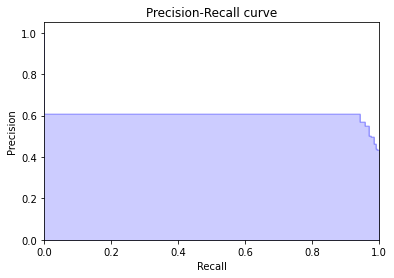

In [107]:
# 4

visualizar_curva_ROC(modelo, X, y)

print("\n################################################")
print("\n CON CAMBIO EN EL PARAMETRO CLASS_WEIGTH \n")
print("--------------------------------------- \n")

visualizar_curva_ROC(modelo_2, X, y)

Al cambiar el parámetro class_weight se observa cómo el modelo pasa de ser regular (con un área por debajo del 0.7) a bueno (mayor a 0.7 e inferior a 0.8).

En síntesis, el modelo se comporta mejor con el parámetro cambiado. Es decir, se relaciona mejor y_predic con y_true y con X.

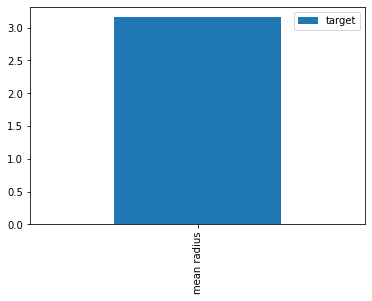


##################################################

 CON CAMBIO EN EL PARAMETRO CLASS_WEIGTH
----------------------------------------



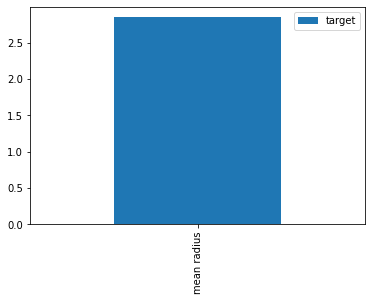

In [108]:
# 1

visualizar_parametros(modelo, mostrar_bias=False, feature_names=X.columns, target_name=y.name)

print("\n##################################################")
print("\n CON CAMBIO EN EL PARAMETRO CLASS_WEIGTH")
print("----------------------------------------\n")

visualizar_parametros(modelo_2, mostrar_bias=False, feature_names=X.columns, target_name=y.name)

Para la Regresión Logística se utiliza la Regresión Lineal convinada con la Función Logística (Sigmoidea) como se muestra en el siguiente gráfico.


La función sigmoidea funciona como distribución de probabilidades y está representada por la línea curva azul.

Tiene dos asíntotas horizontales:
*   Tiende a 1 cuando x tiende a + infinito.
*   Tiende a 0 cuando x tiende a - infinito.

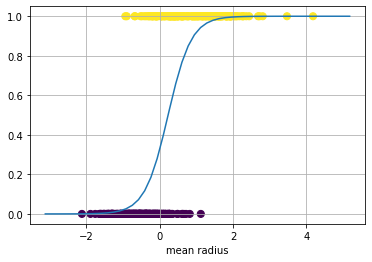


########################################################

 CON CAMBIO EN EL PARAMETRO CLASS_WEIGTH 

--------------------------------------- 



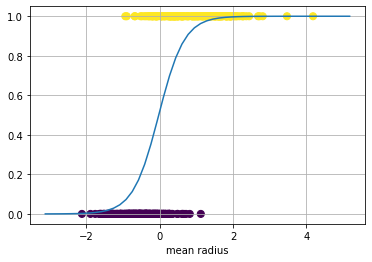

In [109]:
# 6

visualizar_curva_logistica(modelo, X_train, y_train, feature_name=X.columns[0])

print("\n########################################################")
print("\n CON CAMBIO EN EL PARAMETRO CLASS_WEIGTH \n")
print("--------------------------------------- \n")

visualizar_curva_logistica(modelo_2, X_train, y_train, feature_name=X.columns[0])

En este último gráfico se puede observar cómo al cambiar el parámetro class_weight se desplaza la curva hacia la izquierda, atribuyéndole mayor peso a la variable 1.